In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf 

2024-02-15 07:45:56.309231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 07:45:56.309346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 07:45:56.478036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/apple-stock-price-from-19802021/AAPL.csv')
print("Initial dataset:")
print(df.head())

Initial dataset:
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600


In [3]:
duplicate_dates = df[df.duplicated(subset='Date')]
print("Duplicate Dates:")
print(duplicate_dates)
print("\nChecking for missing values:")
print(df.isnull().sum())

Duplicate Dates:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []

Checking for missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [4]:
# Convert 'Date' column to datetime format and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

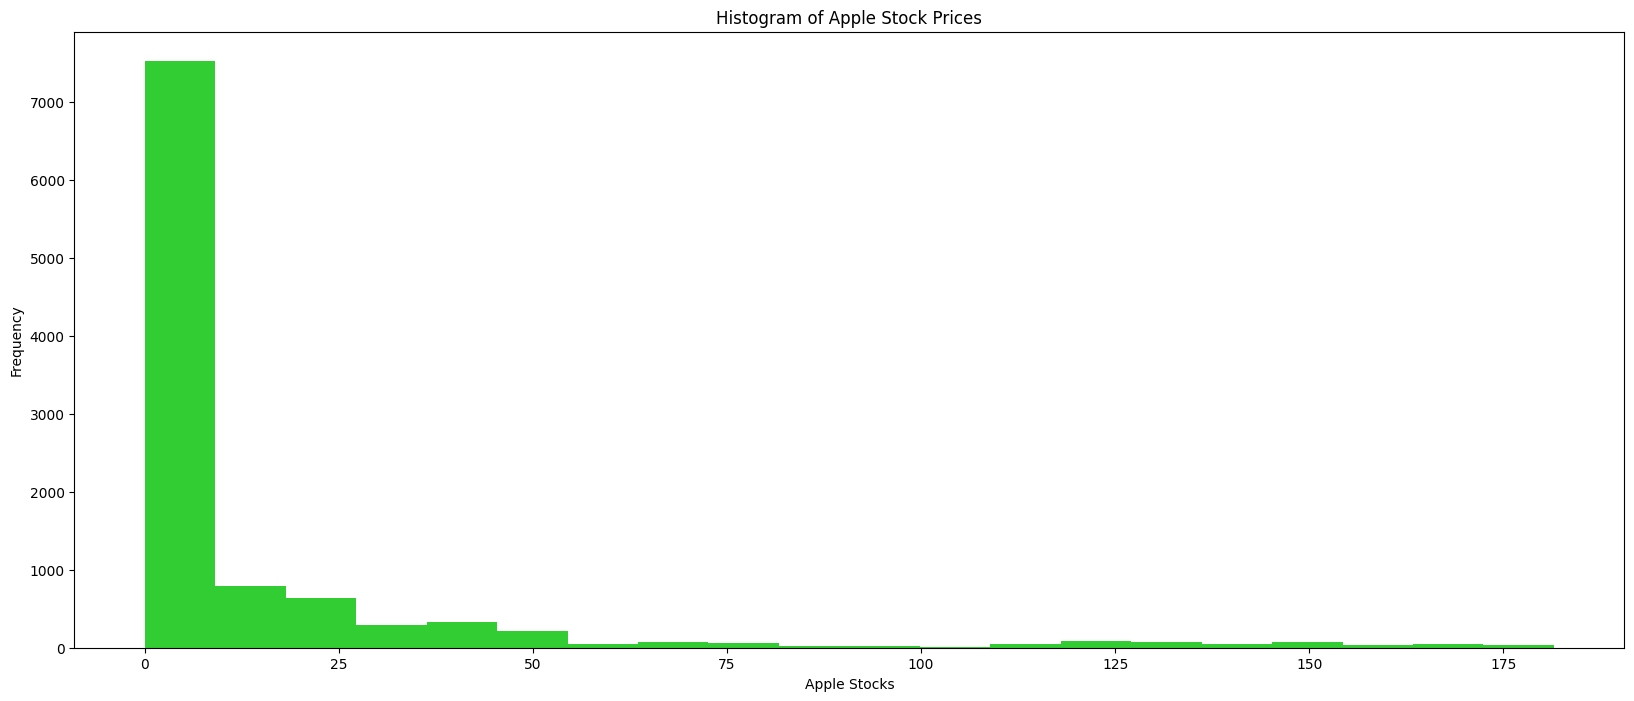

In [5]:
# Plotting Histogram
plt.figure(figsize=(20, 8))
plt.hist(df['Adj Close'], bins=20, color='LimeGreen')
plt.title('Histogram of Apple Stock Prices')
plt.xlabel('Apple Stocks')
plt.ylabel('Frequency')
plt.show()

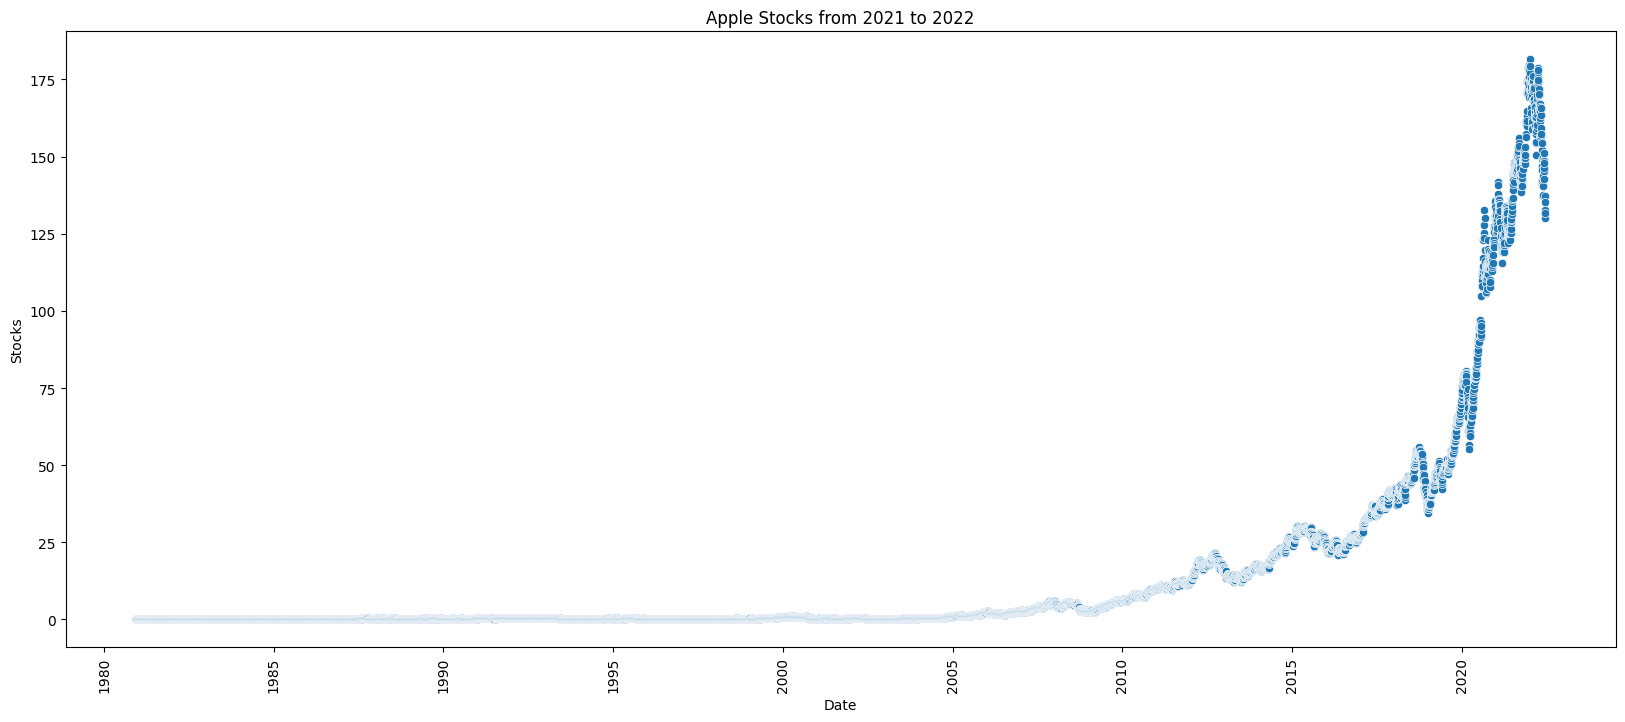

In [6]:
# Plotting Scatter Plot
plt.figure(figsize=(20, 8))
sns.scatterplot(df['Adj Close'])
plt.title('Apple Stocks from 2021 to 2022')
plt.ylabel('Stocks')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

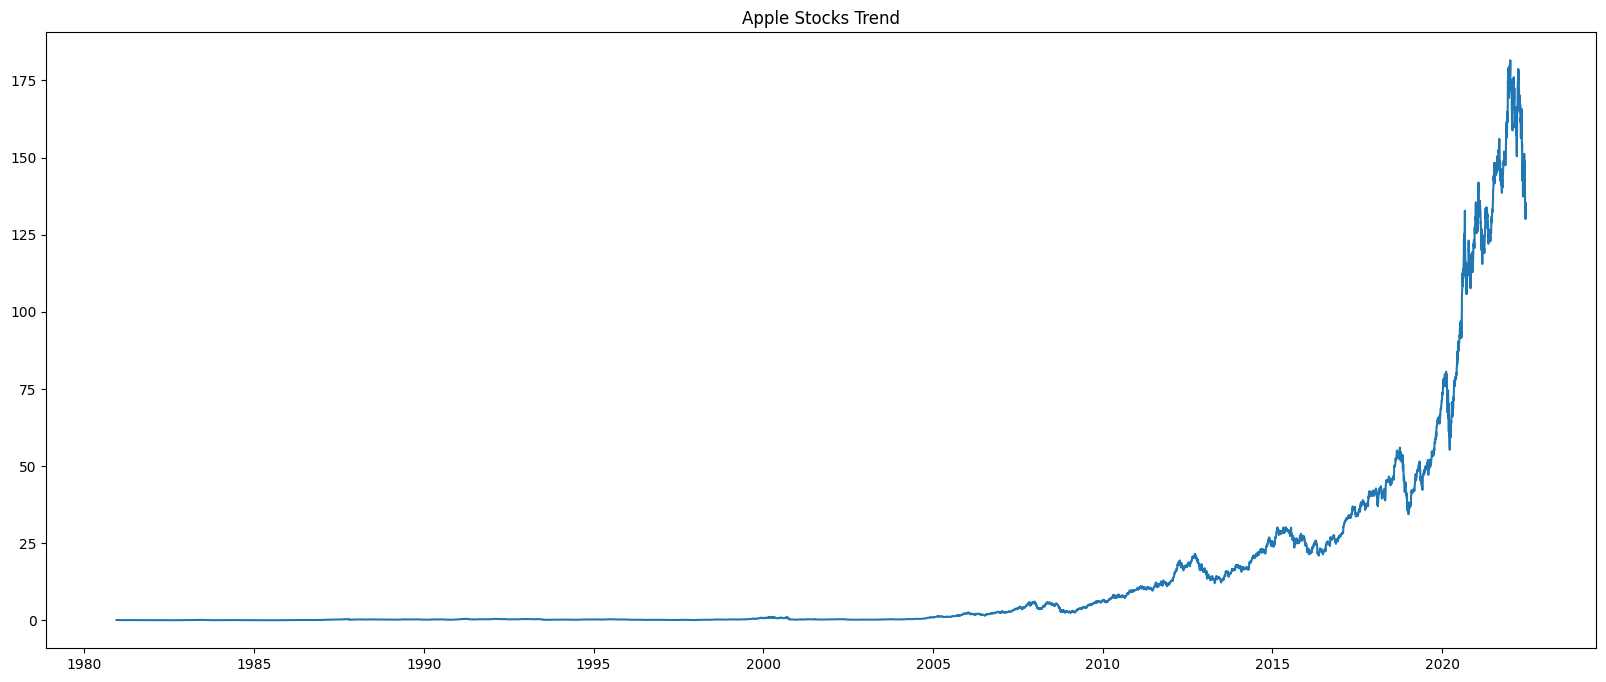

In [7]:
# Plotting Time Series Trend
plt.figure(figsize=(20, 8))
plt.plot(df['Adj Close'])
plt.title('Apple Stocks Trend')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

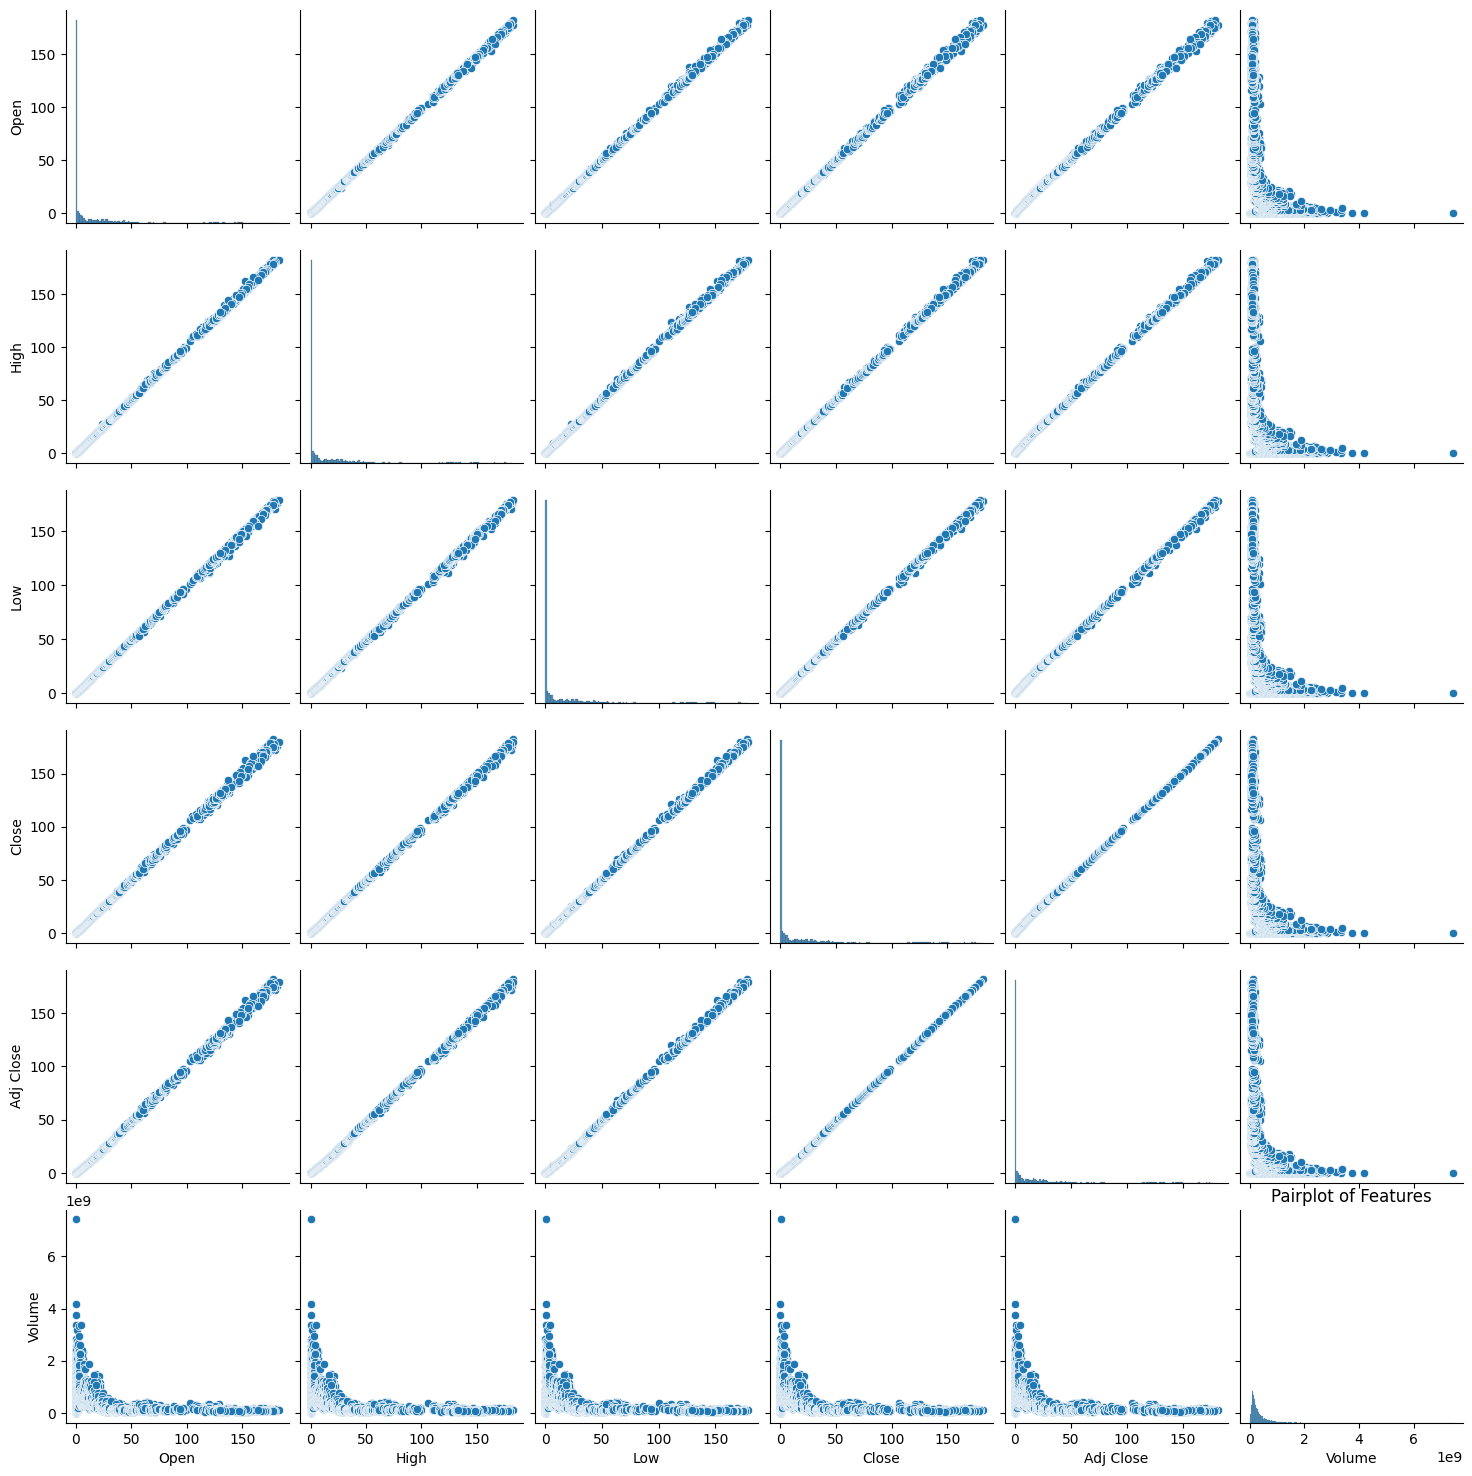

In [8]:
# Pairplot to visualize relationships between different features
sns.pairplot(df)
plt.title('Pairplot of Features')
plt.show()

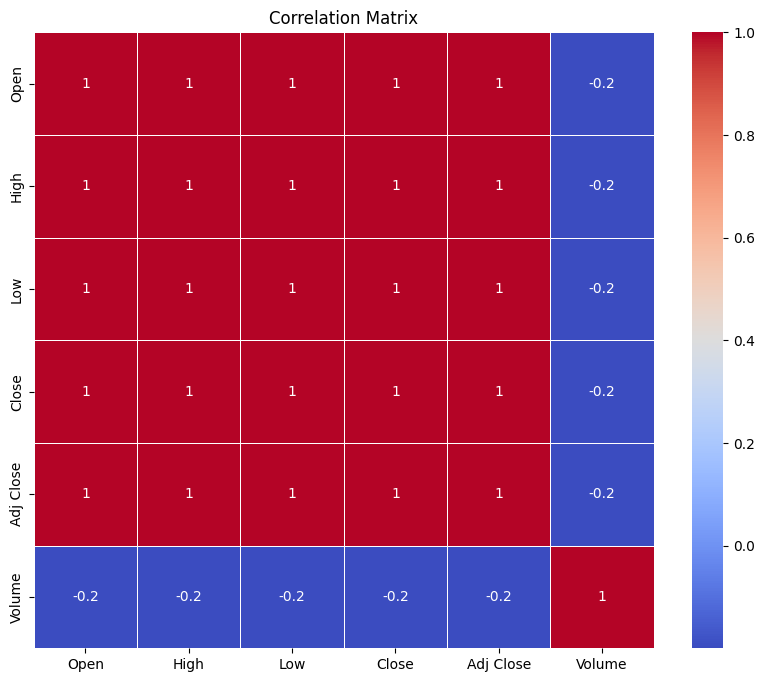

In [9]:
# Correlation matrix to identify linear relationships
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Extract the 'Close' column for further analysis
closing_prices = df.filter(['Close']).values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

# Create training dataset
train_data = scaled_prices[:int(len(scaled_prices) * 0.95), :]
train_features, train_labels = [], []

# Prepare training data
for i in range(60, len(train_data)):
  train_features.append(train_data[i-60:i, 0])
  train_labels.append(train_data[i, 0])

train_features, train_labels = np.array(train_features), np.array(train_labels)

# Reshape the data for LSTM
train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model to the training data
model.fit(train_features, train_labels, epochs=25, batch_size=32)

# Create the testing dataset
test_data = scaled_prices[int(len(scaled_prices) * 0.95) - 60:, :]
x_test, y_test = [], closing_prices[int(len(closing_prices) * 0.95):, :]

# Prepare testing data
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/25


I0000 00:00:1707983189.535843      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


309/309 [==============================] - 9s 10ms/step - loss: 2.2329e-04
Epoch 2/25
309/309 [==============================] - 3s 10ms/step - loss: 3.9636e-05
Epoch 3/25
309/309 [==============================] - 3s 10ms/step - loss: 3.1685e-05
Epoch 4/25
309/309 [==============================] - 3s 9ms/step - loss: 2.5710e-05
Epoch 5/25
309/309 [==============================] - 3s 9ms/step - loss: 2.1398e-05
Epoch 6/25
309/309 [==============================] - 3s 10ms/step - loss: 1.8518e-05
Epoch 7/25
309/309 [==============================] - 3s 9ms/step - loss: 2.2734e-05
Epoch 8/25
309/309 [==============================] - 3s 9ms/step - loss: 1.4100e-05
Epoch 9/25
309/309 [==============================] - 3s 10ms/step - loss: 1.4599e-05
Epoch 10/25
309/309 [==============================] - 3s 9ms/step - loss: 1.4226e-05
Epoch 11/25
309/309 [==============================] - 3s 9ms/step - loss: 1.6084e-05
Epoch 12/25
309/309 [==============================] - 3s 9ms/step - 

In [11]:
training_set = df.iloc[:int(len(closing_prices) * 0.95)]
validation_set = df.iloc[int(len(closing_prices) * 0.95):]
validation_set.loc[:, 'Predictions'] = predictions.copy()

/tmp/ipykernel_26/3477981132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set.loc[:, 'Predictions'] = predictions.copy()


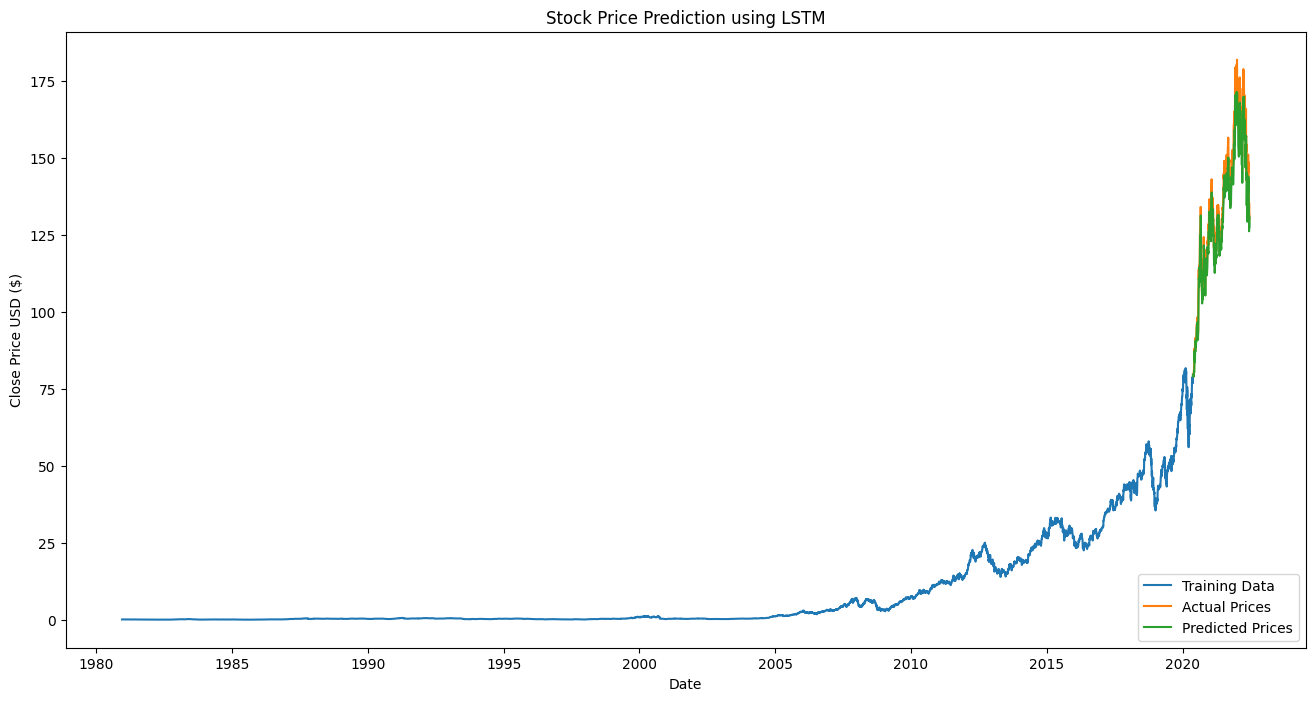

In [12]:
# Visualize the predicted prices compared to actual prices
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(training_set['Close'], label='Training Data')
plt.plot(validation_set[['Close', 'Predictions']], label=['Actual Prices', 'Predicted Prices'])
plt.legend(loc='lower right')
plt.show()

In [13]:
# Model Evaluation Metrics
mse_lstm = mean_squared_error(validation_set['Close'], validation_set['Predictions'])
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(validation_set['Close'], validation_set['Predictions'])
mape_lstm = np.mean(np.abs((validation_set['Close'] - validation_set['Predictions']) / validation_set['Close'])) * 100
r2_lstm = r2_score(validation_set['Close'], validation_set['Predictions'])

print('\nLSTM Model Evaluation:')
print(f'MSE: {mse_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'MAE: {mae_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%')
print(f'R2 Score: {r2_lstm:.2f}')

# Additional Insights
start_date_predictions = validation_set.index[0]
print(f'The LSTM model predictions start from {start_date_predictions}')


LSTM Model Evaluation:
MSE: 37.71
RMSE: 6.14
MAE: 5.09
MAPE: 3.55%
R2 Score: 0.93
The LSTM model predictions start from 2020-05-21 00:00:00
